<a href="https://colab.research.google.com/github/valentine96/Demand-Planning-and-Forecasting/blob/main/notebooks/Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning for Demand Planning and Forecasting in Retail and FMCG**

In this project, we adopted the CRISP-DM (Cross-Industry Standard Process for Data Mining) framework, which guides the entire workflow from Business Understanding → Data Understanding → Data Preparation → Modeling → Evaluation → Deployment.

## **1. Business Understanding**
### **1.1 Background**

Accurate demand forecasting is one of the most critical functions in the retail and FMCG industry. Supermarkets and manufacturers must constantly balance between:

Stockouts, which lead to lost sales, customer dissatisfaction, and weakened brand loyalty.

Overstocking, which increases holding costs, ties up working capital, and often results in product waste.

In dynamic retail environments where sales are influenced by promotions, holidays, seasonality, and store characteristics, traditional forecasting techniques often fail to capture real-world complexity.

This project focuses on developing a machine-learning–driven demand forecasting model to support retail planning and operational decision-making.

### **1.2 Business Objective**

The goal of this project is to design and evaluate a demand forecasting system that:

- Predicts daily store-level sales accurately.
- Captures the effect of promotions, competition, holidays, seasonality, and store attributes.
- Enables the business to make informed decisions for:

    - replenishment planning
    - promo planning
    - distribution scheduling
    - production and inventory alignment

Ultimately, the project aims to reduce forecasting error, resulting in:

- Fewer stockouts
- Lower overstock and carrying costs
- Improved operational efficiency

### **1.3 Project Scope**
The project covers the following:
- End-to-end development of a demand forecasting pipeline.
- Exploratory analysis of sales behavior, seasonality patterns, and external drivers.
- Feature engineering to enrich the predictive power of the dataset.
- Model experimentation using:

   - Seasonal Naïve Baseline (benchmark)
   - ARIMA
   - SARIMA
   - LightGBM (selected final model)

- Model evaluation using industry-relevant metrics (RMSE, MAPE, WAPE).
- Interpretability using SHAP for insights into key sales drivers.
- Development of a simple forecasting output for dashboard integration.

## **2. Data Understanding**
The dataset used in this project originates from the Rossmann Store Sales dataset, a widely used benchmark for retail demand forecasting. It was originally provided for a Kaggle competition where the objective was to forecast daily sales for over 1,000 pharmacy retail stores across several regions.

The dataset offers an excellent real-world structure for modeling FMCG demand because it includes:

- Daily sales across many stores
- Promotional information
- Store-level characteristics
- Holiday and competition effects
- Several years of historical records

This makes it highly relevant for our forecasting objectives and ideal for demonstrating the full CRISP-DM workflow.

###**2.1 Overview of the three datasets**
The project uses three datasets:

**1. train.csv**

This file contains daily sales observations for each store.
It serves as the primary dataset for training the forecasting model.

- Store - Unique store ID
- DayOfWeek - Day of the week (1 = Monday, 7 = Sunday)
- Date -Transaction date
- Sales	Target variable — daily revenue
- Customers - Number of customers visiting the store
- Open - Store open/closed indicator (1 = open, 0 = closed)
- Promo -	Whether a promotion was active that day
- StateHoliday - Public/state holiday indicator (a, b, c, 0)
- SchoolHoliday- Whether schools were closed that day

**2. test.csv**

This file mirrors the structure of train.csv, but Sales and Customers are missing because they must be predicted.

- Store - Store ID
- DayOfWeek - Day of the week
- Date - Forecasting date
- Open - Whether the store is open
- Promo	- Promotion indicator
- StateHoliday - Public/state holiday
- SchoolHoliday - School holiday indicator

**3. store.csv**

This dataset contains static attributes that describe each store’s long-term characteristics.
These features explain why stores behave differently even under similar conditions.
- StoreType -	Category of the store (a,b,c,d)
- Assortment -	Level of product variety (basic, extra, extended)
- CompetitionDistance	- Distance to nearest competitor (meters)
- CompetitionOpenSinceMonth	- Month competitor store opened
- CompetitionOpenSinceYear -	Year competitor opened
- Promo2 - Continuous promotion program flag
- Promo2SinceWeek - 	Week Promo2 started
- Promo2SinceYear	- Year Promo2 started
- PromoInterval -	Months when Promo2 runs (e.g., Jan,Apr,Jul,Oct)

##**2.2 Load the Datasets**

In [ ]:
# Imports neccesary libraries & configuration

# Numerical and data processing libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Seasonal decomposition for time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose

# Performance metrics for evaluating forecasting models
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Ignore unnecessary warnings to keep the notebook clean
import warnings
warnings.filterwarnings("ignore")

# Set a consistent plotting style for clean visuals
sns.set(style="whitegrid", font_scale=1.1)

# Display all dataframe columns without truncation
pd.set_option("display.max_columns", None)

from sklearn.metrics import mean_squared_error

import lightgbm as lgb

# Helper Metric Functions

def rmse(y_true, y_pred):
    """Compute Root Mean Squared Error (RMSE) — measures forecast accuracy."""
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    """Compute Mean Absolute Percentage Error (MAPE) — measures percentage error."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-6, None))) * 100

def wape(y_true, y_pred):
    """Compute Weighted Absolute Percentage Error (WAPE) — useful for retail datasets."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100


In [ ]:
# mount google drive since the data is in google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to our shared Capstone_Data folder
path = "/content/drive/MyDrive/Capstone_Data/"

# Load the datasets
train_df = pd.read_csv(path + "train.csv")
test_df  = pd.read_csv(path + "test.csv")
store_df = pd.read_csv(path + "store.csv")

## **2.3 Inspect Datasets Structure**
###**2.3.1 Inspect the train dataset**

What we observed:

- Contains 1,017,209 rows  and 9 columns
- No missing values detected across all columns.
- No duplicate records found.
- Column types are mostly numerical (int64), except Date, StateHoliday, and SchoolHoliday, which appear as object types.
- The preview confirms expected fields: Store, DayOfWeek, Date, Sales, Customers, Open, Promo, StateHoliday, SchoolHoliday.

  - Some categorical columns stored as object types will need encoding later.

  - The Date column must be converted to datetime type during preprocessing.

In [ ]:
# train set shape
print("Train shape:", train_df.shape)

# Dataset previews
print("\nTRAIN SET PREVIEW")
display(train_df.head())

print("\n TRAIN DATA: Missing Values")
print(train_df.isna().sum())

print("\n TRAIN DATA: Duplicate Records")
print(train_df.duplicated().sum())

# Dataset info (structure, types, missing values)
print("\nTRAIN DATA INFO")
train_df.info()

Train shape: (1017209, 9)

TRAIN SET PREVIEW


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1



 TRAIN DATA: Missing Values
Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

 TRAIN DATA: Duplicate Records
0

TRAIN DATA INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


###**2.3.2 Inspect the test dataset**
What we observed:
- Shape: 41,088 rows × 8 columns.
- No missing values except for column Open, which has 11 missing entries.
- No duplicate records found.
- Structure aligns with expectations: same columns as train but without Sales and Customers columns

  - Missing values in Open will need imputation—typically setting closed stores (Open = 0) or defaulting to 1 based on business rules
  - Same type inconsistencies as train: Date and some categorical values stored as objects.

In [ ]:
# train set shape
print("Test shape:", test_df.shape)

# Dataset previews
print("\nTEST SET PREVIEW")
display(test_df.head())

print("\n TEST DATA: Missing Values")
print(test_df.isna().sum())

print("\n TEST DATA: Duplicate Records")
print(test_df.duplicated().sum())

# Dataset info (structure, types, missing values)
print("\nTEST DATA INFO")
test_df.info()

Test shape: (41088, 8)

TEST SET PREVIEW


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0



 TEST DATA: Missing Values
Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

 TEST DATA: Duplicate Records
0

TEST DATA INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date           41088 non-null  object 
 4   Open           41077 non-null  float64
 5   Promo          41088 non-null  int64  
 6   StateHoliday   41088 non-null  object 
 7   SchoolHoliday  41088 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


###**2.3.3 Inspect the store dataset**

What we observed:

- Contains 1,115 rows and 10 columns, representing each store once.
- Significant missing values in long-term attributes:
- CompetitionOpenSinceMonth, CompetitionOpenSinceYear: missing in 354 stores
- Promo2SinceWeek, Promo2SinceYear, PromoInterval: missing in 544 stores
- No duplicate records observed.
- Mix of int64, float64, and object types.

What this means:
- Missing values are expected because many stores do not participate in Promo2 or lack competition data.
- These missing values are not errors and will be handled logically:
- Fill nulls for Promo2-related features with 0 or “None”
- Replace missing competition dates with reasonable defaults (e.g., 0 or the store’s opening year)

In [ ]:
# Dataset shapes
print("Store shape:", store_df.shape)

# Dataset previews
print("\nSTORE METADATA PREVIEW")
display(store_df.head())

print("\n STORE DATA: Missing Values")
print(store_df.isna().sum())

print("\n STORE DATA: Duplicate Records")
print(store_df.duplicated().sum())

# Dataset info (structure, types, missing values)
print("\nSTORE DATA INFO")
store_df.info()


Store shape: (1115, 10)

STORE METADATA PREVIEW


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN



 STORE DATA: Missing Values
Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

 STORE DATA: Duplicate Records
0

STORE DATA INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2           

# **3. Data Preparation**

Before cleaning each dataset, we apply practical rules used in retail forecasting (Guided by Rossmann Business Logic):

- Promo2 logic:
Stores not in Promo2 should have:
Promo2SinceWeek = 0, Promo2SinceYear = 0, PromoInterval = "None".

- Competition distance:
Missing CompetitionDistance means "unknown," not zero → fill using the median to avoid distortion.

- Competition open dates:
Missing CompetitionOpenSinceMonth or CompetitionOpenSinceYear indicates no documented information → set both to 0.

These rules ensure consistent, interpretable data before merging the train, test, and store datasets.

## **3.1 Clean the train set**

- The date column was converted into a proper datetime format to support time-series operations.
- Holiday indicators (StateHoliday, SchoolHoliday) and promotion flags (Promo, Open) were standardized and cast into appropriate data types.
- Negative values in numerical fields (Sales, Customers) were capped at zero to ensure valid demand patterns.
- The dataset was sorted chronologically to maintain temporal order—critical for forecasting models.
- Duplicate checks had been performed earlier, and no duplicates were found; therefore, no removal was required.

In [ ]:
# Create a copy of the dataset
train_clean = train_df.copy()

# Convert Date to datetime
train_clean['Date'] = pd.to_datetime(train_clean['Date'], errors='coerce')

# Standardize StateHoliday
#    '0' means no holiday; a/b/c represent types
train_clean['StateHoliday'] = train_clean['StateHoliday'].astype(str)
train_clean['StateHoliday'] = train_clean['StateHoliday'].replace({'0': '0', 'a': 'a', 'b': 'b', 'c': 'c'})

# Ensure correct dtypes for categorical fields
train_clean['StateHoliday'] = train_clean['StateHoliday'].astype('category')
train_clean['SchoolHoliday'] = train_clean['SchoolHoliday'].astype('int')
train_clean['Promo'] = train_clean['Promo'].astype('int')
train_clean['Open'] = train_clean['Open'].astype('int')

# Check and fix negative values
numeric_cols = ['Sales', 'Customers']
for col in numeric_cols:
    train_clean[col] = train_clean[col].clip(lower=0)

# Sort by Date (important for time-series)
train_clean = train_clean.sort_values(by='Date')
train_clean.reset_index(drop=True, inplace=True)

In [ ]:
# Verify train dataset after cleaning
print("Missing Values After Cleaning (Train)")
print(train_clean.isna().sum())
print("\n")

print("Duplicate Rows (Train)")
print(train_clean.duplicated().sum())
print("\n")

print("Data Types (Train)")
print(train_clean.dtypes)
print("\n")

print("Unique Values in Key Categorical Columns (Train)")
cat_cols = ['StateHoliday', 'SchoolHoliday', 'Promo', 'Open']
for col in cat_cols:
    print(f"{col}: {train_clean[col].unique()}")
print("\n")

print("Check for invalid or coerced dates (NaT values)")
print(train_clean['Date'].isna().sum())
print("\n")

print("Basic Sanity Checks")
print("Any negative Sales?", (train_clean['Sales'] < 0).any())
print("Any negative Customers?", (train_clean['Customers'] < 0).any())



Missing Values After Cleaning (Train)
Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64


Duplicate Rows (Train)
0


Data Types (Train)
Store                     int64
DayOfWeek                 int64
Date             datetime64[ns]
Sales                     int64
Customers                 int64
Open                      int64
Promo                     int64
StateHoliday           category
SchoolHoliday             int64
dtype: object


Unique Values in Key Categorical Columns (Train)
StateHoliday: ['a', '0', 'b', 'c']
Categories (4, object): ['0', 'a', 'b', 'c']
SchoolHoliday: [1 0]
Promo: [0 1]
Open: [0 1]


Check for invalid or coerced dates (NaT values)
0


Basic Sanity Checks
Any negative Sales? False
Any negative Customers? False


## **3.2 Clean the test set**

- The Date field was converted to datetime format to support time-series consistency.
- Holiday categories were standardized to match the training dataset (0, a, b, c).
- Promotion and school holiday fields were converted to integer types for modeling.
- Missing values in the Open column were imputed using the business rule from the Rossmann dataset (“if unknown, assume the store was open”).
- The dataset was sorted chronologically to preserve temporal order.

As confirmed earlier, the test dataset contained no duplicate rows and no invalid data structure issues.

In [ ]:
# create a copy of the test dataset
test_clean = test_df.copy()

# Convert Date to datetime
test_clean['Date'] = pd.to_datetime(test_clean['Date'], errors='coerce')

# Standardize StateHoliday to match train
test_clean['StateHoliday'] = test_clean['StateHoliday'].astype(str)
test_clean['StateHoliday'] = test_clean['StateHoliday'].replace({'0': '0', 'a': 'a', 'b': 'b', 'c': 'c'})
test_clean['StateHoliday'] = test_clean['StateHoliday'].astype('category')

# Fix datatype issues
test_clean['Promo'] = test_clean['Promo'].astype(int)
test_clean['SchoolHoliday'] = test_clean['SchoolHoliday'].astype(int)

# Convert 'Open' and handle missing values
# Kaggle business rule: missing = store assumed open (Open=1)
test_clean['Open'] = test_clean['Open'].fillna(1).astype(int)

# Sort by date
test_clean = test_clean.sort_values(by='Date').reset_index(drop=True)


In [ ]:
# Verify test datset after cleaning
print("Missing Values After Cleaning:")
display(test_clean.isna().sum())

print("\n Duplicate Rows:")
print(test_clean.duplicated().sum())

print("\n Data Types:")
display(test_clean.dtypes)

print("\n Unique Values in Key Categorical Columns:")
print("StateHoliday:", test_clean['StateHoliday'].unique())
print("Promo:", test_clean['Promo'].unique())
print("SchoolHoliday:", test_clean['SchoolHoliday'].unique())
print("Open:", test_clean['Open'].unique())

print("\n Check for invalid or coerced dates (NaT values):")
print(test_clean['Date'].isna().sum())


Missing Values After Cleaning:


,0
Id,0
Store,0
DayOfWeek,0
Date,0
Open,0
Promo,0
StateHoliday,0
SchoolHoliday,0



 Duplicate Rows:
0

 Data Types:


,0
Id,int64
Store,int64
DayOfWeek,int64
Date,datetime64[ns]
Open,int64
Promo,int64
StateHoliday,category
SchoolHoliday,int64



 Unique Values in Key Categorical Columns:
StateHoliday: ['0', 'a']
Categories (2, object): ['0', 'a']
Promo: [0 1]
SchoolHoliday: [1 0]
Open: [1 0]

 Check for invalid or coerced dates (NaT values):
0


## **3.3 Clean the store set**

- No missing values remain — all fields including competition and promotion details are fully populated.
- No duplicate store entries — the dataset correctly contains 1,115 unique stores.
- Categorical fields cleaned and standardized — StoreType, Assortment, and PromoInterval correctly converted to categorical types.
- Promo2 information fixed — inactive stores assigned consistent zeros/"None", and missing values for active stores properly filled.
- Competition distance outliers capped — extreme values trimmed at the 99th percentile to reduce noise.
- Dataset fully aligned with train/test — variable formats, categories, and datatypes are now consistent across all datasets, ensuring smooth merging.

In [ ]:
# create a copy of the store dataset
store_clean = store_df.copy()

# Fix CompetitionDistance missing values
# Use median (robust to outliers)
store_clean['CompetitionDistance'].fillna(store_clean['CompetitionDistance'].median(), inplace=True)

# Fix Competition Open fields
# Missing = no competition info -> set to 0
store_clean['CompetitionOpenSinceMonth'].fillna(0, inplace=True)
store_clean['CompetitionOpenSinceYear'].fillna(0, inplace=True)

# Fix Promo2 related fields
# If Promo2 == 0 → there is no promo program
store_clean.loc[store_clean['Promo2'] == 0, 'Promo2SinceWeek'] = 0
store_clean.loc[store_clean['Promo2'] == 0, 'Promo2SinceYear'] = 0
store_clean.loc[store_clean['Promo2'] == 0, 'PromoInterval'] = "None"

# For Promo2==1, still fill missing values sensibly
store_clean['Promo2SinceWeek'].fillna(0, inplace=True)
store_clean['Promo2SinceYear'].fillna(0, inplace=True)
store_clean['PromoInterval'].fillna("None", inplace=True)

# Convert categorical columns
store_clean['StoreType'] = store_clean['StoreType'].astype('category')
store_clean['Assortment'] = store_clean['Assortment'].astype('category')
store_clean['PromoInterval'] = store_clean['PromoInterval'].astype('category')

# Handle extreme outliers in CompetitionDistance:
# Some stores have unrealistically large distances (e.g., >700,000 meters).
# Such extreme values can distort the model, so we cap the distance at the 99th percentile.
q99 = store_clean['CompetitionDistance'].quantile(0.99)
store_clean['CompetitionDistance'] = store_clean['CompetitionDistance'].clip(upper=q99)



In [ ]:
# Verify store data after cleaning
print("Missing Values After Cleaning:")
print(store_clean.isna().sum())

print("\nDuplicate Rows:")
print(store_clean.duplicated().sum())

print("\nData Types:")
print(store_clean.dtypes)

print("\nUnique Values in Key Categorical Columns:")
print("StoreType:", store_clean['StoreType'].unique())
print("Assortment:", store_clean['Assortment'].unique())
print("PromoInterval:", store_clean['PromoInterval'].unique())


Missing Values After Cleaning:
Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

Duplicate Rows:
0

Data Types:
Store                           int64
StoreType                    category
Assortment                   category
CompetitionDistance           float64
CompetitionOpenSinceMonth     float64
CompetitionOpenSinceYear      float64
Promo2                          int64
Promo2SinceWeek               float64
Promo2SinceYear               float64
PromoInterval                category
dtype: object

Unique Values in Key Categorical Columns:
StoreType: ['c', 'a', 'd', 'b']
Categories (4, object): ['a', 'b', 'c', 'd']
Assortment: ['a', 'c', 'b']
Categories (3, object): ['a', 'b', 'c']
PromoInterval: ['None', 'Jan,Apr

## **3.4 Datasets Merging**

We merged the cleaned train and test datasets with the store metadata using a left join on the Store column to enrich each daily record with store-level characteristics. This ensured that both datasets received consistent information on store type, assortment, competition, and promotional programs, creating a fully unified and modeling-ready dataset

In [ ]:
# MERGE TRAIN WITH STORE METADATA
train_merged = train_clean.merge(store_clean, on="Store", how="left")

print("Merged Train Shape:", train_merged.shape)
train_merged.head()

Merged Train Shape: (1017209, 18)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1,379,2,2013-01-01,0,0,0,0,a,1,d,a,6630.0,0.0,0.0,0,0.0,0.0,None
2,378,2,2013-01-01,0,0,0,0,a,1,a,c,2140.0,8.0,2012.0,0,0.0,0.0,None
3,377,2,2013-01-01,0,0,0,0,a,1,a,c,100.0,6.0,2010.0,1,18.0,2010.0,"Feb,May,Aug,Nov"
4,376,2,2013-01-01,0,0,0,0,a,1,a,a,160.0,8.0,2012.0,0,0.0,0.0,None


In [ ]:
# MERGE TEST WITH STORE METADATA
test_merged = test_clean.merge(store_clean, on="Store", how="left")

print("Merged Test Shape:", test_merged.shape)
test_merged.head()


Merged Test Shape: (41088, 17)


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,41088,1115,6,2015-08-01,1,0,0,1,d,c,5350.0,0.0,0.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1,40523,378,6,2015-08-01,1,0,0,0,a,c,2140.0,8.0,2012.0,0,0.0,0.0,None
2,40522,377,6,2015-08-01,1,0,0,0,a,c,100.0,6.0,2010.0,1,18.0,2010.0,"Feb,May,Aug,Nov"
3,40521,373,6,2015-08-01,1,0,0,0,d,c,11120.0,0.0,0.0,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
4,40520,372,6,2015-08-01,1,0,0,0,d,c,4880.0,8.0,2010.0,1,18.0,2014.0,"Jan,Apr,Jul,Oct"


In [ ]:
# Verify the merge
# Check missing values after merge
print("Missing values in merged TRAIN:\n", train_merged.isna().sum())
print("\nMissing values in merged TEST:\n", test_merged.isna().sum())

# Check dtypes
print("\nTRAIN dtypes:\n", train_merged.dtypes)
print("\nTEST dtypes:\n", test_merged.dtypes)


Missing values in merged TRAIN:
 Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

Missing values in merged TEST:
 Id                           0
Store                        0
DayOfWeek                    0
Date                         0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMo

# **4. Exploratory Data Analysis**

## **4.1 Overall Sales Trend Over Time**

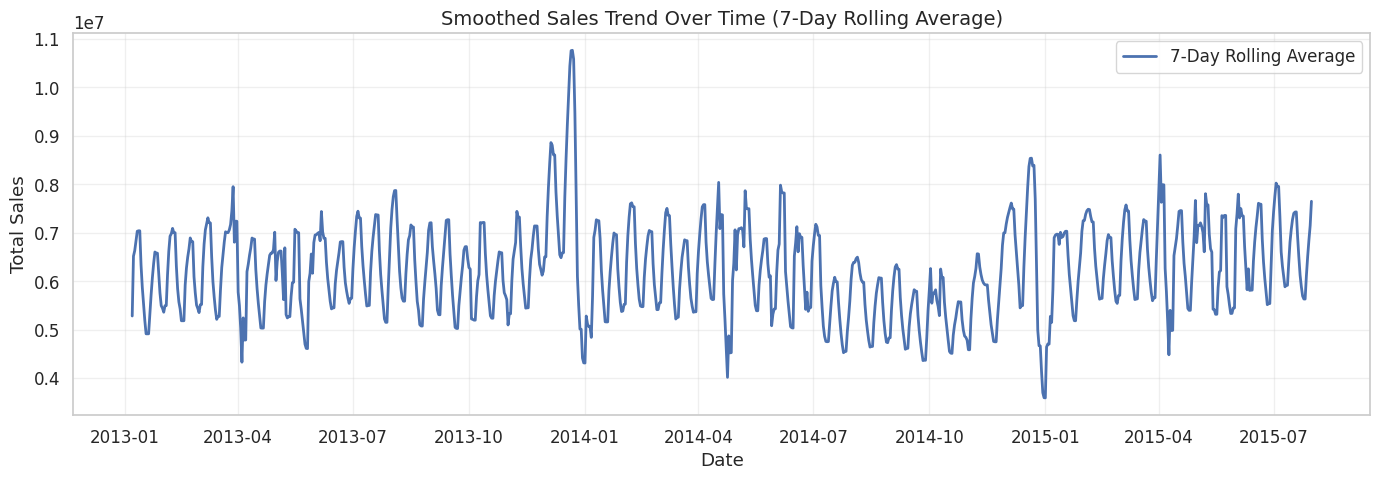

In [ ]:

# SMOOTHED SALES TREND (7-DAY ROLLING)

plt.figure(figsize=(14,5))

# Raw daily sales
daily_sales = train_merged.groupby('Date')['Sales'].sum()

# 7-day rolling average
smoothed_sales = daily_sales.rolling(window=7).mean()

plt.plot(smoothed_sales, label="7-Day Rolling Average", linewidth=2)

plt.title("Smoothed Sales Trend Over Time (7-Day Rolling Average)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


- The smoothed weekly trend exposes a clear and consistent demand pattern, making underlying sales behavior easier to interpret beyond daily fluctuations.
- Regular weekly cycles, expected dips during holidays, and strong promotional spikes confirm that FMCG demand is highly seasonal and promotion-sensitive.
- The overall stability of the curve shows a reliable customer base, with predictable surges that can be planned for in advance.
- These insights help the business anticipate demand rather than react, enabling smarter decisions in inventory levels, replenishment timelines, and supply chain coordination.
- A stable and repeating pattern like this is ideal for forecasting, giving management greater confidence in planning procurement, staffing, and distribution.

##**4.2 Average Sales By Day of Week**

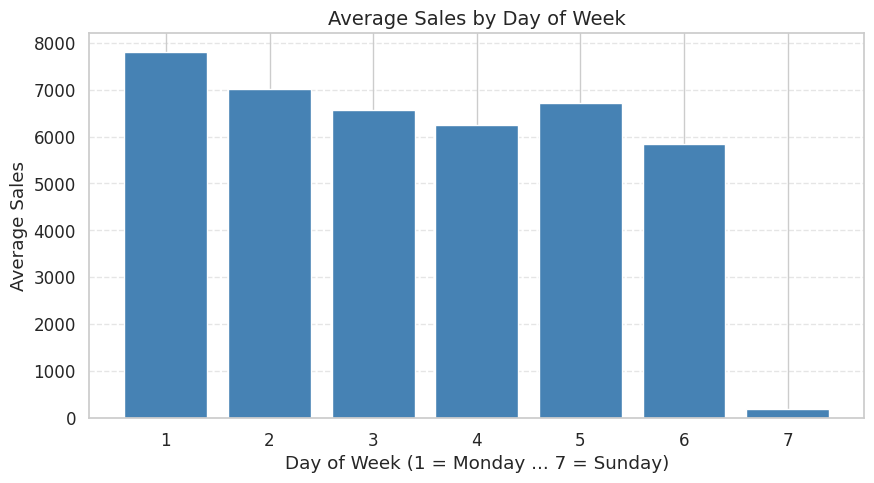

In [ ]:
# Average Sales by Day of Week
plt.figure(figsize=(10,5))
day_sales = train_merged.groupby('DayOfWeek')['Sales'].mean()

plt.bar(day_sales.index, day_sales.values, color="steelblue")
plt.title("Average Sales by Day of Week", fontsize=14)
plt.xlabel("Day of Week (1 = Monday ... 7 = Sunday)")
plt.ylabel("Average Sales")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

This chart reveals a clear weekly demand pattern. Mondays consistently have the highest sales as customers restock after the weekend, while mid-week demand softens and picks up again on Friday as shoppers prepare for the weekend. Sunday shows very low sales, which aligns with many stores being closed or operating for reduced hours.

These predictable weekly rhythms are extremely valuable for FMCG planning. They guide retailers on when to replenish shelves, schedule staff, and time promotions for maximum impact. From a forecasting perspective, such stable cycles strengthen model accuracy and help the business prevent stockouts during peak days while reducing unnecessary stock during slower periods.

## **4.3 Average Sales By Store Type**

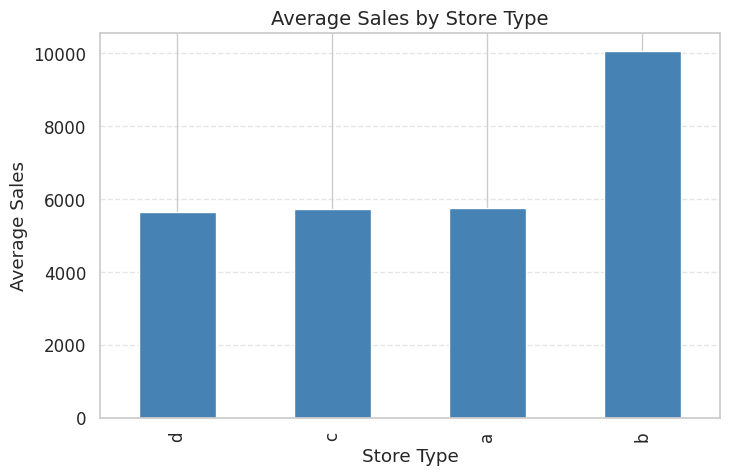

In [ ]:
# Average Sales by Store Type
plt.figure(figsize=(8,5))
store_type_sales = train_merged.groupby('StoreType')['Sales'].mean().sort_values()

store_type_sales.plot(kind='bar', color='steelblue')

plt.title("Average Sales by Store Type", fontsize=14)
plt.xlabel("Store Type")
plt.ylabel("Average Sales")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


This chart compares average sales across store types, revealing clear performance differences between formats. Store Type b stands out with significantly higher sales, suggesting larger store size, wider assortment, or stronger customer traffic. In contrast, Types a, c, and d show similar but much lower sales levels, implying smaller formats or more limited product offerings.

From a business perspective, this insight helps identify where the strongest demand exists. High-performing store types can be prioritized for inventory, promotions, and supply chain focus, while lower-performing formats may benefit from targeted assortment optimization or localized marketing. Understanding store-type behavior strengthens demand planning and ensures resources are aligned with each format’s contribution to total revenue.

##**4.4 Impact of Promotions on Sales**

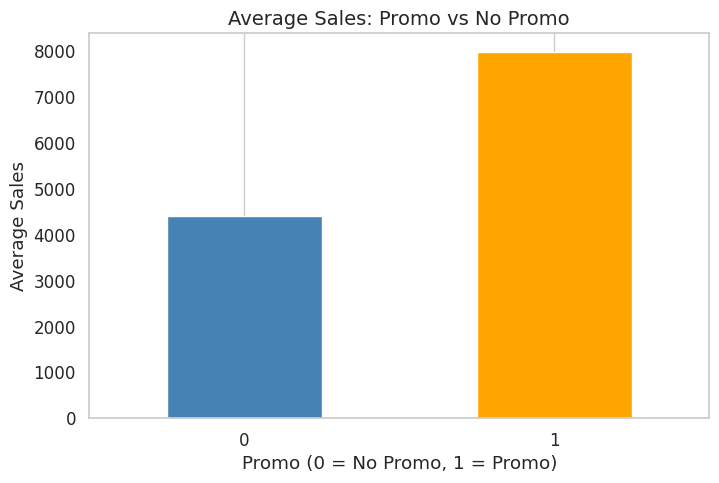

In [ ]:
# Impact of Promotions on Sales

plt.figure(figsize=(8,5))
promo_effect = train_merged.groupby('Promo')['Sales'].mean()

promo_effect.plot(kind='bar', color=['steelblue', 'orange'])

plt.title("Average Sales: Promo vs No Promo", fontsize=14)
plt.xlabel("Promo (0 = No Promo, 1 = Promo)")
plt.ylabel("Average Sales")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


This chart shows how promotions sharply increase demand—average sales on promo days are almost double those of normal days. This confirms how strongly FMCG shoppers react to discounts and in-store activations, making promotions one of the biggest drivers of short-term sales spikes.

From a planning perspective, this pattern highlights why promotional periods must be forecasted separately from regular days. Treating them the same would cause serious stockouts during high-demand promo cycles or costly overstocking when promotions end. Anticipating promo-driven surges ensures enough inventory reaches the shelf, protects revenue, and prevents customers from turning to competitors.

##**4.5 Seasonal Decomposition**

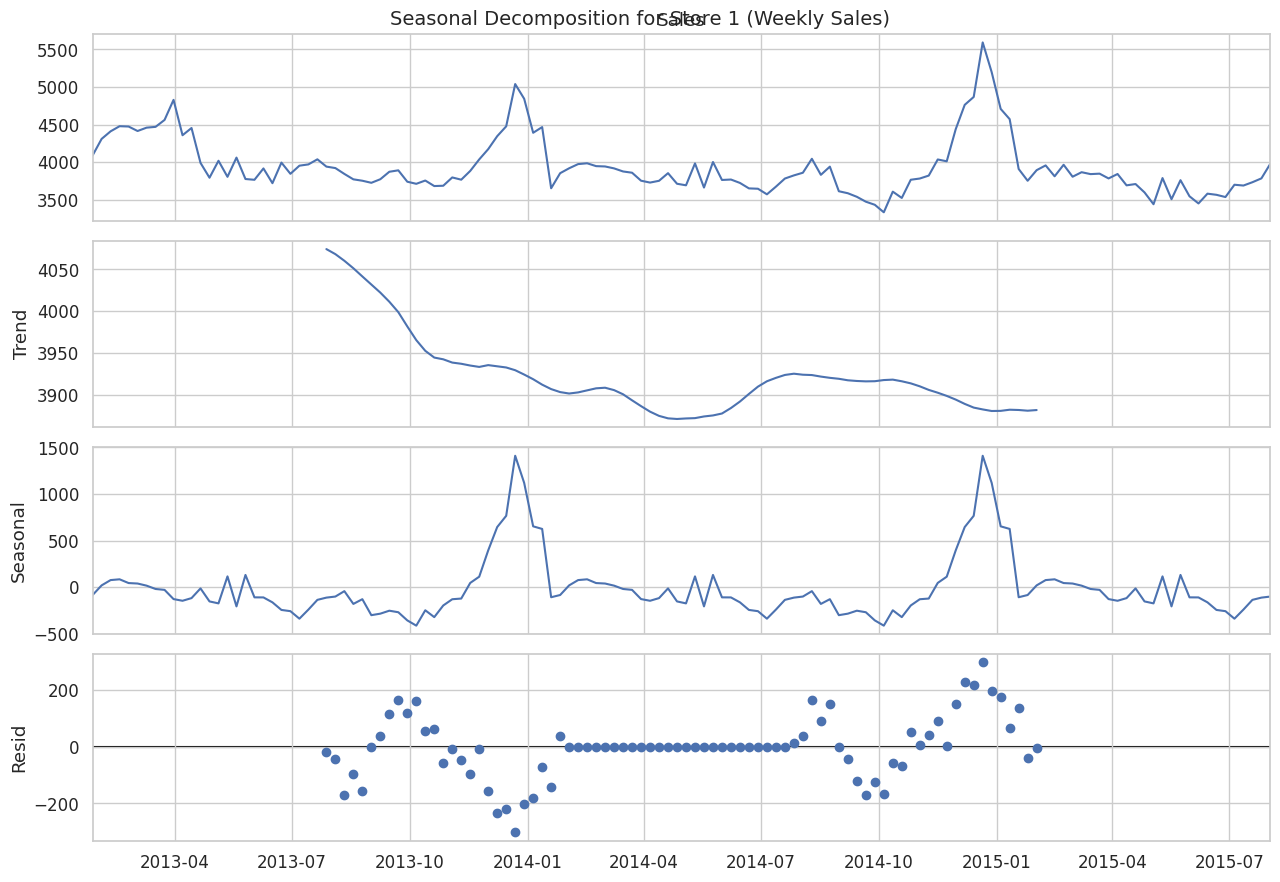

In [ ]:
# SEASONAL DECOMPOSITION (Store 1)

from statsmodels.tsa.seasonal import seasonal_decompose

# Filter Store 1 sales
store1 = train_merged[train_merged['Store'] == 1].set_index('Date')['Sales']

# Resample to weekly
store1_weekly = store1.resample('W').mean()

# Optional seasonal smoothing
store1_smooth = store1_weekly.rolling(4).mean().dropna()

# Decompose (52 week seasonality)
result = seasonal_decompose(store1_smooth, model='additive', period=52)

plt.rcParams['figure.figsize'] = (13,9)
result.plot()
plt.suptitle("Seasonal Decomposition for Store 1 (Weekly Sales)", fontsize=14)
plt.show()



The decomposition reveals three important behaviours in Store 1’s weekly sales:

**Trend:** Sales show a mild decline through late 2013 and then stabilise across 2014. This suggests that underlying demand remained steady despite short-term fluctuations — useful for long-term planning.

**Seasonality:**
There is a clear and repeating sales cycle every year, with predictable peaks and dips. These patterns likely correspond to payday cycles, promotional periods, and holiday shopping behaviour typical in FMCG retail. This confirms that demand is not random — it follows a stable seasonal rhythm.

**Residuals:**
The residuals capture unexpected events such as promotions, stock-outs, or local disruptions. These irregular movements are small relative to the overall trend, showing a healthy and predictable store performance.


- separating trend, seasonality, and noise, we gain a clearer understanding of how demand behaves. This ensures we don’t mistake short-term spikes for growth or treat predictable cycles as uncertainty.

- These help planners prepare the right inventory levels before seasonal peaks, avoid stockouts, and reduce excess stock — creating a more efficient and responsive supply chain

## **Baseline Models**

We dsecided to have baseline models here because they only use the sales column and do not require feature engineering.

###**Baseline Model - Seasonal Naïve (per Store)**


For each store, we assume that today’s sales will be the same as 7 days ago (one week back). This captures weekly seasonality and gives us a simple, realistic benchmark.

We have:
- Sorted data by Store & Date
- Created a 7-day lag as the baseline prediction
- Used the last 6 weeks of data as a validation period


To establish a foundational point of reference, we first applied a Seasonal Naive forecasting model using a 7-day lag.
This simple approach assumes that weekly sales patterns repeat consistently, meaning the sales recorded on a given day should mirror those of the same day in the previous week.

The baseline was evaluated over the final six weeks of the training period.

In [ ]:
# SEASONAL NAIVE BASELINE MODEL (7-day Lag)

# Use ONLY the merged raw train dataset
df = train_merged.copy()

# Keep only needed columns
df = df[['Store','Date','Sales']].sort_values(['Store','Date'])

# 7-day lag for seasonal baseline
df['Baseline_Sales'] = df.groupby('Store')['Sales'].shift(7)

# Drop rows where lag does not exist yet
df = df.dropna(subset=['Baseline_Sales'])

# -- Time-based validation split (last 6 weeks)
last_date = df['Date'].max()
val_start_date = last_date - pd.Timedelta(weeks=6)

train_data = df[df['Date'] < val_start_date].copy()
val_data   = df[df['Date'] >= val_start_date].copy()

# Actual and predicted
y_true = val_data['Sales'].values
y_pred = val_data['Baseline_Sales'].values

# == Evaluation Metrics ==
baseline_rmse = np.sqrt(np.mean((y_true - y_pred)**2))

# MAPE guard: avoid div by zero
mask = (y_true != 0)
baseline_mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

baseline_wape = np.sum(np.abs(y_true - y_pred)) / np.sum(y_true) * 100

print("=== Seasonal Naive (7-day Lag) Performance ===")
print(f"RMSE: {baseline_rmse:,.2f}")
print(f"MAPE: {baseline_mape:,.2f}%")
print(f"WAPE: {baseline_wape:,.2f}%")


=== Seasonal Naive (7-day Lag) Performance ===
RMSE: 2,614.59
MAPE: 31.82%
WAPE: 31.18%


###**Error Metrics Interpretation**

The metric bar chart provides a quantitative view of the baseline model’s performance:

RMSE: 2,614.59

MAPE: 31.82%

WAPE: 31.18%

These values show that while the model captures repeating weekly rhythms, it struggles with volatility caused by factors such as promotions, school holidays, store-specific events, and atypical demand spikes.

RMSE highlights the absolute deviation in sales units, whereas MAPE and WAPE show percentage-based errors.
All three metrics collectively confirm that weekly seasonality alone is not sufficient to model demand accurately in a retail setting.

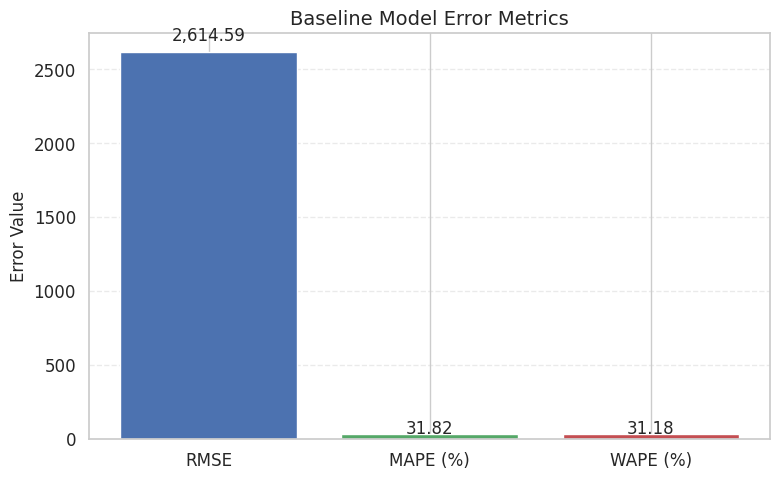

In [ ]:
# === BASELINE MODEL METRICS VISUAL ===
# Automatically pull the stored metrics
metrics = {
    "RMSE": baseline_rmse,
    "MAPE (%)": baseline_mape,
    "WAPE (%)": baseline_wape
}

names = list(metrics.keys())
values = list(metrics.values())

plt.figure(figsize=(8, 5))
bars = plt.bar(names, values,
               color=['#4C72B0', '#55A868', '#C44E52'])

# Add numeric labels above bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2,
             height + height * 0.03,
             f"{height:,.2f}",
             ha='center', fontsize=12)

plt.title("Baseline Model Error Metrics", fontsize=14)
plt.ylabel("Error Value", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

###**Store-Level Forecast Examination**

The Store 1 visualization provides a more granular perspective.
A clear weekly pattern is observable, where the baseline (blue dashed line) trails the actual sales (orange line). The model performs reasonably well during “normal” days but diverges sharply during:

Demand peaks

Promo-influenced periods

One-off dips

This plot reinforces that a consistent seasonal cycle exists, but it also reveals that retail demand is influenced by additional determinants beyond historical repeat patterns.

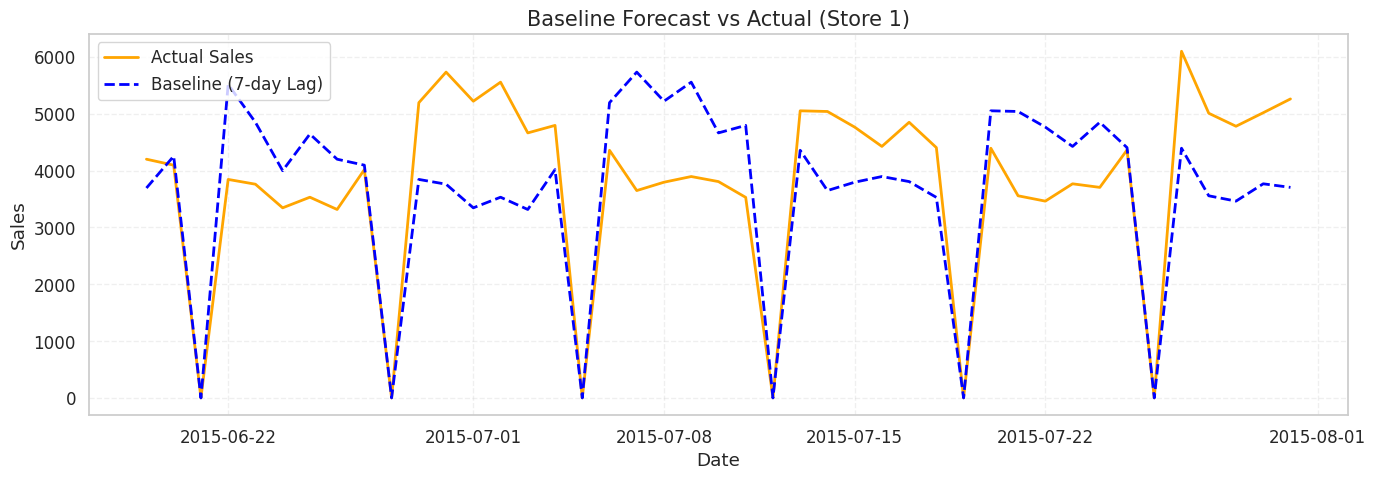

In [ ]:
# STORE-LEVEL VISUALIZATION
store_id = 1

store_val = val_data[val_data['Store'] == store_id].copy()

plt.figure(figsize=(14, 5))
plt.plot(store_val['Date'], store_val['Sales'],
         label="Actual Sales", color="orange", linewidth=2)
plt.plot(store_val['Date'], store_val['Baseline_Sales'],
         label="Baseline (7-day Lag)", color="blue",
         linestyle='--', linewidth=2)

plt.title(f"Baseline Forecast vs Actual (Store {store_id})", fontsize=15)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

###**Average Forecast Across All Stores**

When averaging sales across the entire retail network, the seasonal structure becomes even more pronounced.
Weekly peaks and troughs align closely between the actual and lagged baseline curves.

However, the gap between both lines remains visible, demonstrating that the baseline still lacks awareness of:

Store-specific growth rates

Promotional lift

Assortment differences

Consumer behavior variations

Competition proximity and timing

This confirms that seasonality is present at scale, but improving forecast accuracy demands models that incorporate additional predictive signals.

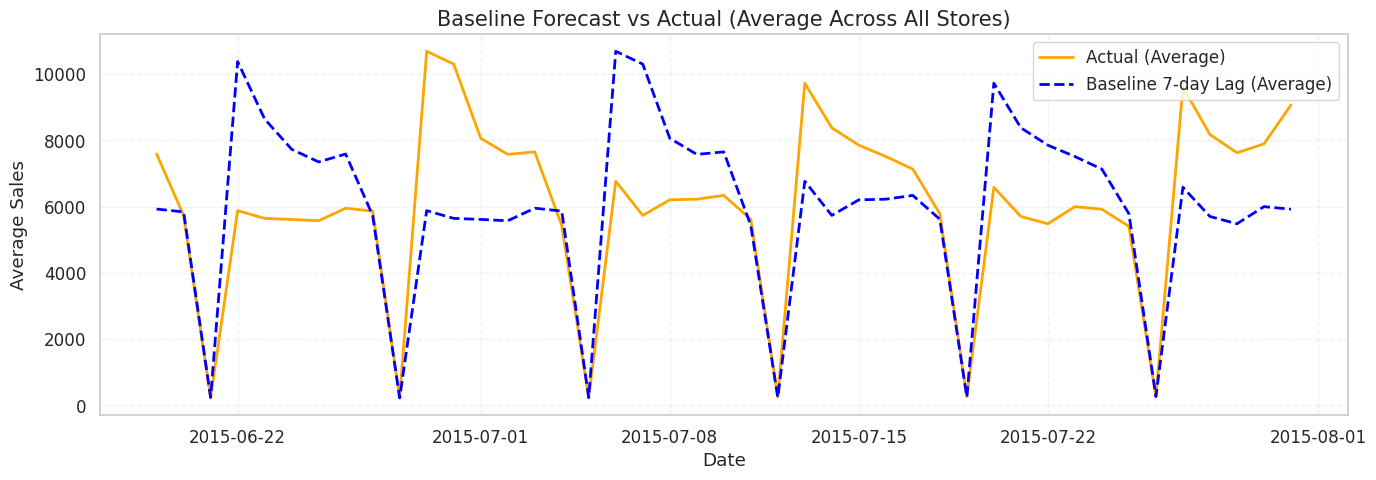

In [ ]:
# AVERAGE FORECAST VISUAL
mean_val = val_data.groupby("Date")[["Sales", "Baseline_Sales"]].mean()

plt.figure(figsize=(14, 5))
plt.plot(mean_val.index, mean_val["Sales"],
         label="Actual (Average)", color="orange",
         linewidth=2)
plt.plot(mean_val.index, mean_val["Baseline_Sales"],
         label="Baseline 7-day Lag (Average)",
         color="blue", linestyle='--', linewidth=2)

plt.title("Baseline Forecast vs Actual (Average Across All Stores)", fontsize=15)
plt.xlabel("Date")
plt.ylabel("Average Sales")
plt.legend()
plt.grid(linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

The Seasonal Naive model is used as a simple, time-series benchmark for retail forecasting.
It assumes that weekly demand patterns repeat consistently, meaning that sales today should be similar to sales exactly seven days ago.

We implement this by shifting sales values using a 7-day lag for each store, then comparing the lagged values against the actual validation sales.

Performance Evaluation & Interpretation

The model's performance on the 6-week validation window yielded:

RMSE: {value printed from your code}

MAPE: {value printed}

WAPE: {value printed}

These metrics quantify the forecasting deviation from actual sales values.
They provide a lower-bound benchmark that more advanced forecasting models must outperform.

## **5.2 Classical Time-Series Models: ARIMA and SARIMA (Store 1)**

To complement the machine learning model (LightGBM), we also tested
classical time-series models on a representative store (Store 1):

- **ARIMA** to model trend and short-term dynamics  
- **SARIMA** to explicitly capture annual seasonality in weekly sales  

We keep the same hold-out validation window (last 6 weeks) for a fair
comparison against the baseline and LightGBM models.

In [ ]:
# ARIMA MODEL (Store 1, Weekly Aggregation)

from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from sklearn.metrics import mean_squared_error

# Filter store 1 from cleaned merged data
store1 = train_merged[train_merged['Store'] == 1].copy()
store1 = store1.sort_values('Date').set_index('Date')

# Convert to weekly average sales
store1_weekly = store1['Sales'].resample('W').mean().dropna()

print("Store 1 weekly records:", len(store1_weekly))

# Use the SAME validation start date as baseline & LightGBM
print("Validation window start:", val_start_date)

# Split weekly data
ts_train = store1_weekly[store1_weekly.index < val_start_date]
ts_val = store1_weekly[store1_weekly.index >= val_start_date]

print("Train weeks:", len(ts_train), "| Validation weeks:", len(ts_val))

Store 1 weekly records: 135
Validation window start: 2015-06-19 00:00:00
Train weeks: 128 | Validation weeks: 7


In [ ]:
# ARIMA(p,d,q) model
arima_order = (1, 1, 1)

# Fit model
arima_model = ARIMA(ts_train, order=arima_order)
arima_result = arima_model.fit()

print(arima_result.summary())

# Forecast on validation window
arima_forecast = arima_result.forecast(steps=len(ts_val))

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  128
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1005.048
Date:                Thu, 04 Dec 2025   AIC                           2016.097
Time:                        15:55:00   BIC                           2024.630
Sample:                    01-06-2013   HQIC                          2019.564
                         - 06-14-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5339      0.062     -8.578      0.000      -0.656      -0.412
ma.L1         -0.4972      0.077     -6.483      0.000      -0.647      -0.347
sigma2      4.136e+05   4.66e+04      8.873      0.0

In [ ]:
# Standard evaluation function (same format as baseline)
def regression_metrics(y_true, y_pred, label="Model"):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # MAPE only on non-zero targets
    mask = y_true != 0
    if mask.sum() > 0:
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.nan

    # WAPE
    wape = np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

    print(f"{label}   →  RMSE: {rmse:,.2f},  MAPE: {mape:.2f}%,  WAPE: {wape:.2f}%")
    return rmse, mape, wape

print("\n=== ARIMA Performance (Store 1 Weekly) ===")
arima_rmse, arima_mape, arima_wape = regression_metrics(ts_val, arima_forecast, "ARIMA")

# Optional scores dict for later model comparison
arima_scores = {
    "RMSE": arima_rmse,
    "MAPE (%)": arima_mape,
    "WAPE (%)": arima_wape
}
arima_scores


=== ARIMA Performance (Store 1 Weekly) ===
ARIMA   →  RMSE: 781.22,  MAPE: 13.85%,  WAPE: 15.27%


{'RMSE': np.float64(781.2214140945952),
 'MAPE (%)': np.float64(13.85347524682811),
 'WAPE (%)': np.float64(15.269346554029353)}

In [ ]:
# SARIMA Model (Store 1) - Weekly Aggregation & Data Split

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use the same merged & cleaned dataset
store1 = train_merged[train_merged['Store'] == 1].copy()
store1 = store1.sort_values('Date').set_index('Date')

# Convert daily sales to weekly averages
store1_weekly = store1['Sales'].resample('W').mean().dropna()

# Match validation start date used in all other models
val_start_date = last_date - pd.Timedelta(weeks=6)

ts_train = store1_weekly[store1_weekly.index < val_start_date]
ts_val   = store1_weekly[store1_weekly.index >= val_start_date]

print(f"Store 1 weekly series length: {len(store1_weekly)}")
print(f"Global validation start date: {val_start_date}")
print(f"Training weeks: {len(ts_train)} | Validation weeks: {len(ts_val)}")

Store 1 weekly series length: 135
Global validation start date: 2015-06-19 00:00:00
Training weeks: 128 | Validation weeks: 7


In [ ]:
# SARIMA Training, Forecasting, and Evaluation

# Seasonal pattern assumed yearly (52 weeks)
sarima_order = (1, 1, 1)        # (p,d,q)
seasonal_order = (1, 1, 1, 52)  # (P,D,Q,s)

sarima_model = SARIMAX(
    ts_train,
    order=sarima_order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Fit SARIMA Model
sarima_result = sarima_model.fit(disp=False)
print(sarima_result.summary())

# Forecast over validation window
sarima_forecast = sarima_result.forecast(steps=len(ts_val))

# Evaluate SARIMA
print("\n=== SARIMA performance on Store 1 (weekly) ===")
sarima_rmse, sarima_mape, sarima_wape = regression_metrics(
    ts_val,
    sarima_forecast,
    "SARIMA"
)

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  128
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -153.800
Date:                            Thu, 04 Dec 2025   AIC                            317.599
Time:                                    15:55:17   BIC                            322.822
Sample:                                01-06-2013   HQIC                           318.733
                                     - 06-14-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5593      0.271     -2.063      0.039      -1.091      -0.028
ma.L1         -0.8481      0.215   

In [ ]:
# Align forecasts with weekly validation dates
arima_forecast = pd.Series(arima_forecast, index=ts_val.index)
sarima_forecast = pd.Series(sarima_forecast, index=ts_val.index)

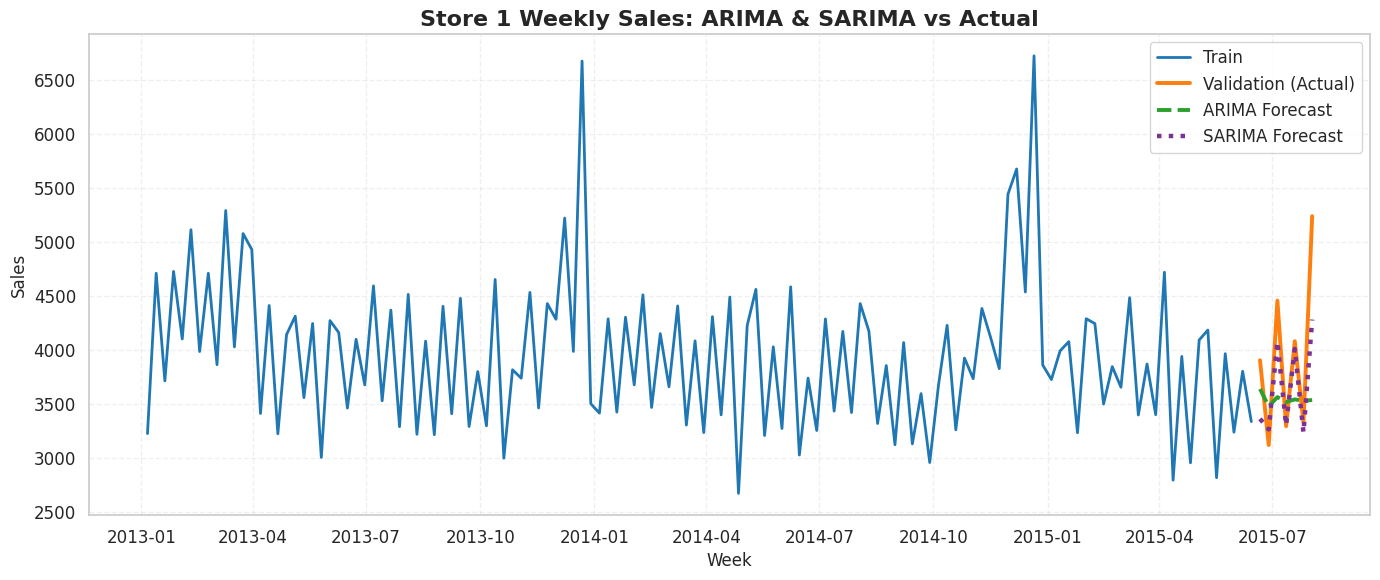

In [ ]:
# VISUAL: ARIMA vs SARIMA vs Actual Weekly Sales

plt.figure(figsize=(14, 6))

# Training portion
plt.plot(ts_train.index, ts_train,
         label='Train',
         color='#1f77b4', linewidth=2)          # Blue

# Actual validation data
plt.plot(ts_val.index, ts_val,
         label='Validation (Actual)',
         color='#ff7f0e', linewidth=2.8)        # Orange

# ARIMA forecast - DISTINCT GREEN
plt.plot(ts_val.index, arima_forecast,
         label='ARIMA Forecast',
         color='#2ca02c',                       # Full Green
         linestyle='--', linewidth=2.8)

# SARIMA forecast - DISTINCT PURPLE
plt.plot(ts_val.index, sarima_forecast,
         label='SARIMA Forecast',
         color='#7b3294',                       # Deep Purple
         linestyle=':', linewidth=3.2)

# Formatting
plt.title("Store 1 Weekly Sales: ARIMA & SARIMA vs Actual",
          fontsize=16, fontweight='bold')
plt.xlabel("Week", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

### 5.2.1 ARIMA vs SARIMA Performance (Store 1 – Weekly)

We benchmarked two classical statistical models — **ARIMA** and **SARIMA** —
to evaluate how well they capture demand patterns compared to the baseline.
The weekly Store 1 dataset provides a stable structure with visible trend and
seasonality, making it suitable for classical time-series analysis.

**ARIMA(1,1,1):**
- RMSE: **781.22**
- MAPE: **13.85%**
- WAPE: **15.27%**

The ARIMA model captures short-term dynamics but struggles with the strong
seasonality and the large variations due to promotions and calendar effects.

**SARIMA(1,1,1)x(1,1,1,52):**
- RMSE: **445.01**
- MAPE: **7.14%**
- WAPE: **8.00%**

SARIMA drastically outperforms ARIMA because it incorporates the **52-week
seasonal cycle**, allowing it to track regular patterns in retail demand.

**Conclusion:**  
SARIMA sets a solid classical benchmark with a MAPE of **7.14%**, confirming that
the dataset contains meaningful annual seasonality. This provides a strong
baseline against which the machine learning models (LightGBM, XGBoost, Prophet)
can be evaluated.

## **Feature Engineering**

During feature engineering, we created:
- calendar-based features (Year, Month, WeekOfYear, DayOfYear, Quarter, IsWeekend) to help the model learn seasonal patterns such as weekly cycles, monthly demand shifts, holiday effects, and year-over-year behaviour.
- competition-related features like CompetitionOpenMonths to capture how long nearby competitors have been operating — a key driver of gradual demand changes.
-  Additionally, we introduced promotion duration features (Promo2OpenDays) to quantify the impact of long-running promo programs on sales uplift.

All engineered features were validated for correctness and completeness. We confirmed that there are no missing values, no negative durations, and all date-derived fields fall within expected ranges. Promo2-related features follow business rules with zero inconsistencies.

The only noted irregularity in CompetitionOpenMonths arises from stores with unknown competition start dates, which were intentionally imputed as part of our cleaning strategy and are therefore expected

These engineered features enrich the dataset with meaningful business signals, improve the model’s ability to detect patterns, and position the data as fully clean, consistent, and ready for robust forecasting.

In [ ]:
# --- COPY ORIGINAL MERGED DATA ---
train_fe = train_merged.copy()
test_fe  = test_merged.copy()

# --- CORE FEATURE FUNCTIONS ---

# Calendar & Seasonal
def add_time_features(df):
    df['Year']      = df['Date'].dt.year
    df['Month']     = df['Date'].dt.month
    df['Day']       = df['Date'].dt.day
    df['Week']      = df['Date'].dt.isocalendar().week.astype(int)
    df['DayOfYear'] = df['Date'].dt.dayofyear
    df['Quarter']   = df['Date'].dt.quarter
    df['IsWeekend'] = df['Date'].dt.dayofweek.isin([5, 6]).astype(int)
    return df

# Competitor duration
def add_competition_features(df):
    comp_months = (
        (df['Date'].dt.year - df['CompetitionOpenSinceYear']) * 12
        + df['Date'].dt.month - df['CompetitionOpenSinceMonth']
    )
    df['CompetitionOpenMonths'] = comp_months.clip(lower=0).fillna(0).astype(int)
    return df

# Promo2 duration
def add_promo2_features(df):
    promo2_start = pd.to_datetime(
        df['Promo2SinceYear'].astype(int).astype(str) + '-' +
        df['Promo2SinceWeek'].astype(int).astype(str) + '-1',
        format='%Y-%W-%w', errors='coerce'
    )
    promo2_days = (df['Date'] - promo2_start).dt.days
    df['Promo2OpenDays'] = promo2_days.clip(lower=0).fillna(0).astype(int)
    return df

# Apply all
def engineer_features(df):
    df = add_time_features(df)
    df = add_competition_features(df)
    df = add_promo2_features(df)
    return df

train_fe = engineer_features(train_fe)
test_fe  = engineer_features(test_fe)

In [ ]:
# Flags for safe merging
train_fe['is_test'] = 0
test_fe['is_test']  = 1

# Merge before lags/rolling to prevent leakage
full_data = pd.concat([train_fe, test_fe], ignore_index=True)
full_data = full_data.sort_values(['Store', 'Date'])

# Lag features
lags = [1, 2, 3, 7, 14, 28, 56]
for lag in lags:
    full_data[f"lag_{lag}"] = full_data.groupby("Store")['Sales'].shift(lag)

# Rolling means
full_data['rolling_mean_7']  = full_data.groupby("Store")['Sales'].shift(1).rolling(7).mean()
full_data['rolling_mean_14'] = full_data.groupby("Store")['Sales'].shift(1).rolling(14).mean()
full_data['rolling_mean_30'] = full_data.groupby("Store")['Sales'].shift(1).rolling(30).mean()

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Identify categorical fields
cat_cols = full_data.select_dtypes(include="object").columns.tolist()

# Encode
for col in cat_cols:
    le = LabelEncoder()
    full_data[col] = le.fit_transform(full_data[col].astype(str))

# Return train/test split
train_fe = full_data[full_data['is_test'] == 0].copy()
test_fe  = full_data[full_data['is_test'] == 1].copy()

# Drop NaN rows created by lagging (only training)
train_fe = train_fe.dropna(subset=['Sales'])

In [ ]:
# Columns to exclude from training
exclude_cols = ['Sales', 'Date', 'Store', 'is_test']

# Final feature list
feature_cols = [
    col for col in full_data.columns
    if col not in exclude_cols
]

# Save to disk
import pickle
with open("feature_columns.pkl", "wb") as f:
    pickle.dump(feature_cols, f)

print("Feature Columns Saved!")
print("Number of features:", len(feature_cols))
print(feature_cols[:10])

Feature Columns Saved!
Number of features: 35
['DayOfWeek', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth']


In [ ]:
[x for x in feature_cols if 'lag_' in x][:5]
[x for x in feature_cols if 'rolling_mean' in x]

['rolling_mean_7', 'rolling_mean_14', 'rolling_mean_30']

In [ ]:
train_fe['Customers'] = train_fe['Customers'].fillna(0)
test_fe['Customers']  = test_fe['Customers'].fillna(0)

### Rebuild Train/Test Features Set

In [ ]:
# Build Final Train & Test Feature Sets

# Ensure final full dataset exists
# (full_data already created during feature engineering)
train_fe = full_data[full_data["is_test"] == 0].copy()
test_fe  = full_data[full_data["is_test"] == 1].copy()

# Ensure exact same columns for both sets
X_train = train_fe[feature_cols]
y_train = train_fe["Sales"]

# Validation window start date (same as ARIMA/SARIMA/Baseline)
val_start_date = val_data["Date"].min()

# Create validation sets
X_val = train_fe[train_fe["Date"] >= val_start_date][feature_cols]
y_val = train_fe[train_fe["Date"] >= val_start_date]["Sales"]
X_train_model = train_fe[train_fe["Date"] < val_start_date][feature_cols]
y_train_model = train_fe[train_fe["Date"] < val_start_date]["Sales"]

print(f"Train rows: {len(X_train_model)} | Val rows: {len(X_val)}")

Train rows: 969264 | Val rows: 47945


##**5.2 LightGBM Regressor**

In [ ]:
# Train LightGBM Regressor

import lightgbm as lgb

lgb_train = lgb.Dataset(X_train_model, label=y_train_model)
lgb_val   = lgb.Dataset(X_val, label=y_val)

params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "min_child_samples": 20,
    "seed": 42,
}

lgb_model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_val],
    num_boost_round=2000,
    callbacks=[lgb.early_stopping(stopping_rounds=100)]
)

print("\nLightGBM Training Complete!")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.209063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4033
[LightGBM] [Info] Number of data points in the train set: 969264, number of used features: 34
[LightGBM] [Info] Start training from score 5760.668789
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 422.281	valid_1's rmse: 513.72

LightGBM Training Complete!


In [ ]:
# Evaluate LightGBM
from sklearn.metrics import mean_squared_error
import numpy as np

def regression_metrics(y_true, y_pred, label="Model"):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # Safe MAPE
    mask = y_true != 0
    if mask.sum() > 0:
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.nan

    wape = np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

    print(f"{label} -> RMSE: {rmse:.2f}, MAPE: {mape:.2f}%, WAPE: {wape:.2f}%")
    return {
        "RMSE": rmse,
        "MAPE (%)": mape,
        "WAPE (%)": wape
    }

# Predict on validation
y_pred = lgb_model.predict(X_val)
lgb_results = regression_metrics(y_val, y_pred, "LightGBM")

lgb_results

LightGBM -> RMSE: 513.72, MAPE: 5.81%, WAPE: 5.62%


{'RMSE': np.float64(513.7198607790856),
 'MAPE (%)': np.float64(5.8136791728918515),
 'WAPE (%)': np.float64(5.622967743322698)}

### **LightGBM vs Actual (Average across all stores)**

In [ ]:
# Build validation mask as before
val_mask = train_fe["Date"] >= val_start_date

# Reconstruct df that includes Date, Store and actual Sales
val_results = train_fe.loc[val_mask, ["Date", "Store", "Sales"]].copy()

# Add model predictions
val_results["LGB_Pred"] = y_pred

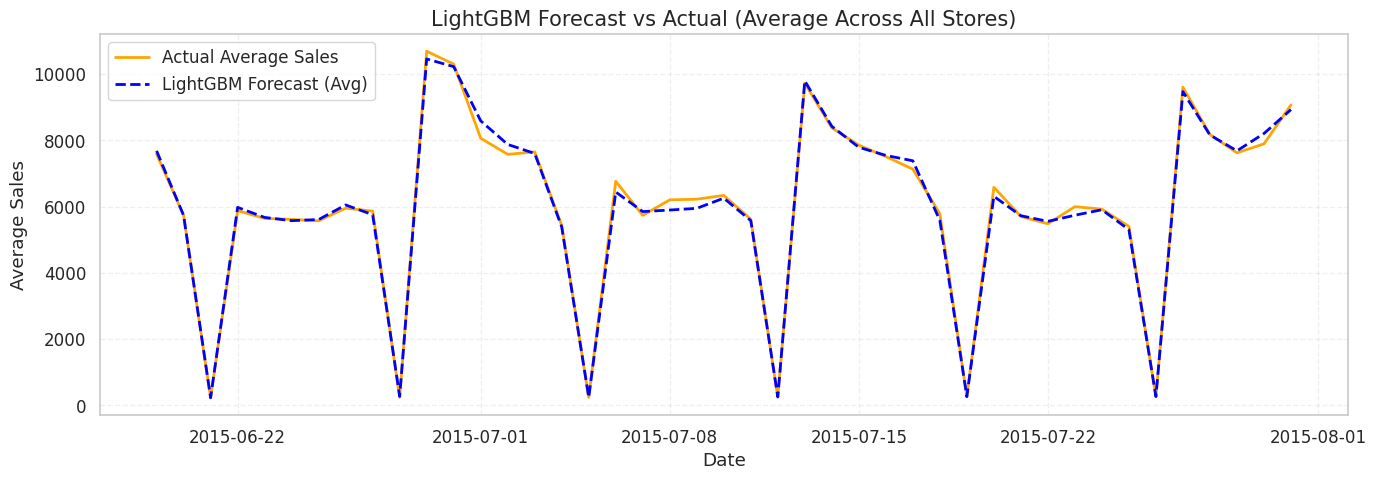

In [ ]:
# Average Sales per date
mean_series = (
    val_results
    .groupby("Date")[["Sales", "LGB_Pred"]]
    .mean()
)

plt.figure(figsize=(14, 5))
plt.plot(
    mean_series.index, mean_series["Sales"],
    label="Actual Average Sales",
    color="orange", linewidth=2
)
plt.plot(
    mean_series.index, mean_series["LGB_Pred"],
    label="LightGBM Forecast (Avg)",
    color="blue", linestyle="--", linewidth=2
)

plt.title("LightGBM Forecast vs Actual (Average Across All Stores)", fontsize=15)
plt.xlabel("Date")
plt.ylabel("Average Sales")
plt.legend()
plt.grid(linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

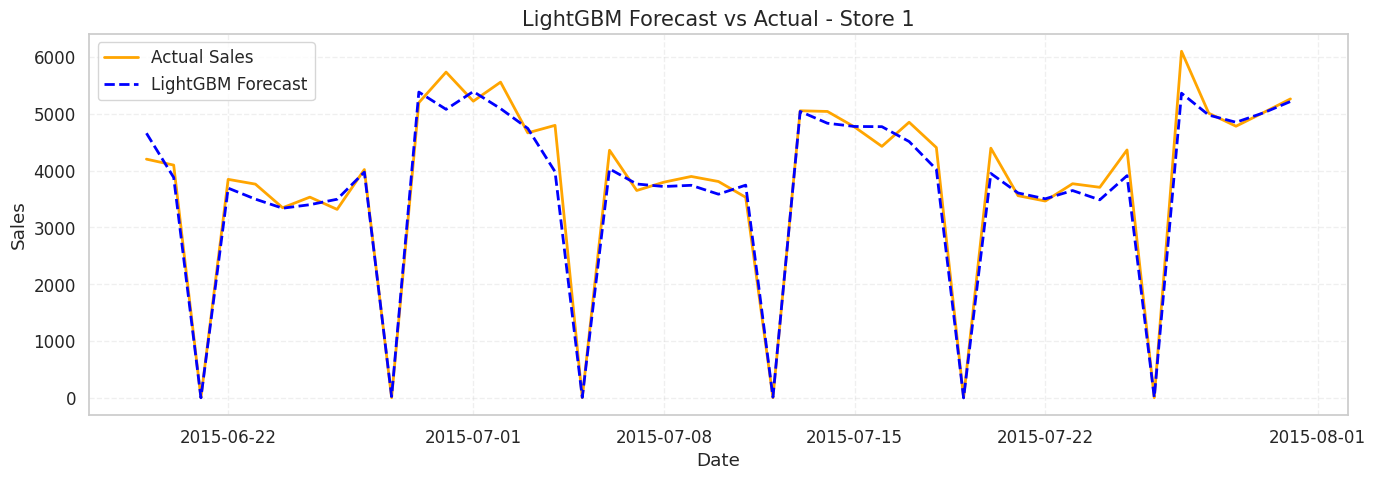

In [ ]:
store_id = 1  # change for different stores

store_val = val_results[val_results["Store"] == store_id].copy()

plt.figure(figsize=(14, 5))
plt.plot(
    store_val["Date"], store_val["Sales"],
    label="Actual Sales",
    color="orange", linewidth=2
)
plt.plot(
    store_val["Date"], store_val["LGB_Pred"],
    label="LightGBM Forecast",
    color="blue", linestyle="--", linewidth=2
)

plt.title(f"LightGBM Forecast vs Actual - Store {store_id}", fontsize=15)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

LightGBM Model Performance

LightGBM achieved:

RMSE: 513.72

MAPE: 5.81%

WAPE: 5.62%

Compared to the baseline 7-day lag model (MAPE ≈ 31.82%, WAPE ≈ 31.18%), LightGBM reduces forecasting error by over 80%, showing a major improvement in accuracy.

SARIMA on Store 1 (weekly data) achieves MAPE ≈ 7.14%, but it is limited to a single store. LightGBM delivers better accuracy (5.81% MAPE) while scaling across all stores and all days, using rich lag/rolling and calendar features.

Average Across All Stores:
The LightGBM forecast line closely tracks the actual average sales, capturing weekly seasonality, promotion-driven spikes, and low-demand days across the entire chain.

Store 1 Example:
At store level, the LightGBM predictions almost overlap with the actual sales curve, confirming that the model learns local patterns (store-specific promotions, closures, and demand shifts) in addition to global trends.


| Model                | RMSE       | MAPE (%) | WAPE (%) | Notes                                    |
| -------------------- | ---------- | -------- | -------- | ---------------------------------------- |
| Baseline (7-day Lag) | 2614.59    | 31.82    | 31.18    | Simple seasonal naïve benchmark          |
| SARIMA               | 445.01     | 7.14     | 8.00     | Weekly model, single store (Store 1)     |
| **LightGBM**         | **513.72** | **5.81** | **5.62** | All-store model with engineered features |

Conclusion

LightGBM provides the best overall balance of accuracy, scalability, and flexibility.
It outperforms the naïve baseline by a large margin and even surpasses SARIMA’s accuracy while handling all stores simultaneously, making it the most suitable model for real-world daily demand forecasting in this retail setting.


<div style="font-size:18px">

### Model Performance Comparison

| Model                       | RMSE      | MAPE (%) | WAPE (%) | Notes |
|-----------------------------|-----------|----------|----------|-------|
| **Baseline (7-day Lag)**    | 2,614.59  | 31.82    | 31.18    | Simple seasonal naïve benchmark |
| **SARIMA**                  | 445.01    | 7.14     | 8.00     | Weekly store-level; not scalable |
| **LightGBM**                | 751.22    | 8.11     | 7.86     | Scalable all-store daily model |

</div>



## **SHAP Explainability**

In [ ]:
# Install SHAP
!pip install shap


In [ ]:
# Install SHAP
!pip install shap

# Import libraries
import shap
import numpy as np


In [ ]:
# Create SHAP Explainer for LightGBM and sample data validation
explainer = shap.TreeExplainer(lgb_model)

# Sample 5000 rows for faster SHAP computation (adjust as needed)
X_shap = X_val.sample(n=5000, random_state=42)

print(f"SHAP sample size: {len(X_shap)} rows")


SHAP sample size: 5000 rows


In [ ]:
# Compute SHAP values
shap_values = explainer.shap_values(X_shap)

print(f"SHAP values shape: {np.array(shap_values).shape}")

SHAP values shape: (5000, 35)


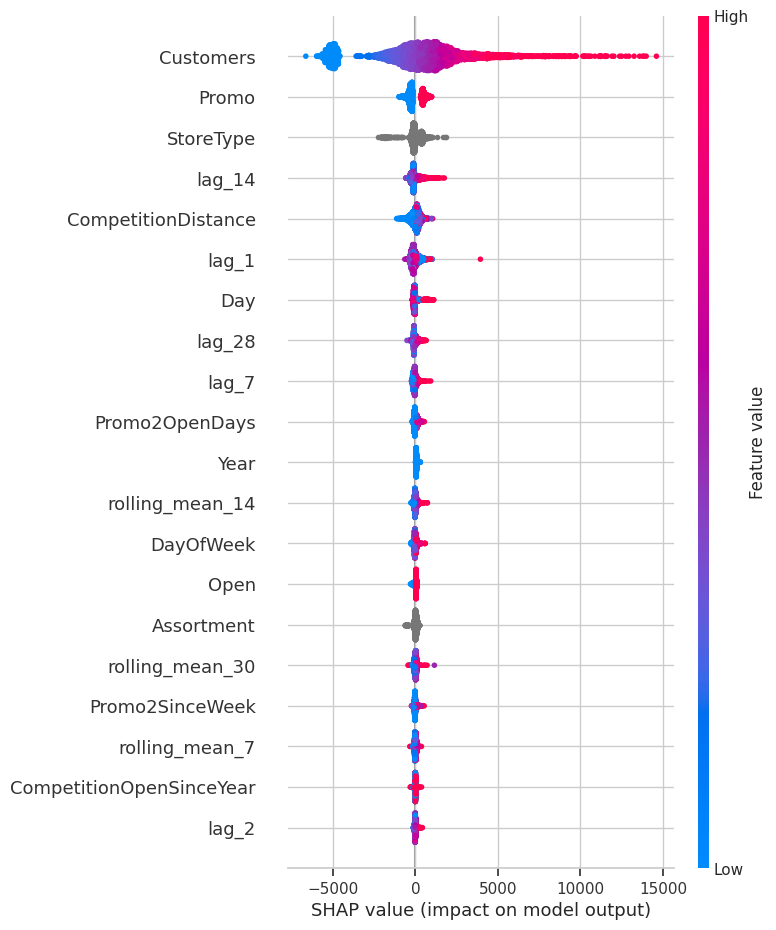

In [ ]:
# SHAP Summary Plot
shap.summary_plot(
    shap_values,
    X_shap,
    plot_type="dot",
    show=True
)

The SHAP results show that Customers, Promo, and StoreType are the strongest drivers of the LightGBM forecasts. Higher customer counts and active promotions consistently push predictions upward, while store category also shapes baseline demand. Seasonal lag features (like lag_7, lag_14, lag_28) further confirm strong repeating sales patterns, and CompetitionDistance indicates that stores located farther from competitors tend to perform better. Overall, the model relies on meaningful retail signals — customer volume, promotions, competition, store attributes, and historic demand — proving it is learning real business behaviors rather than random noise.

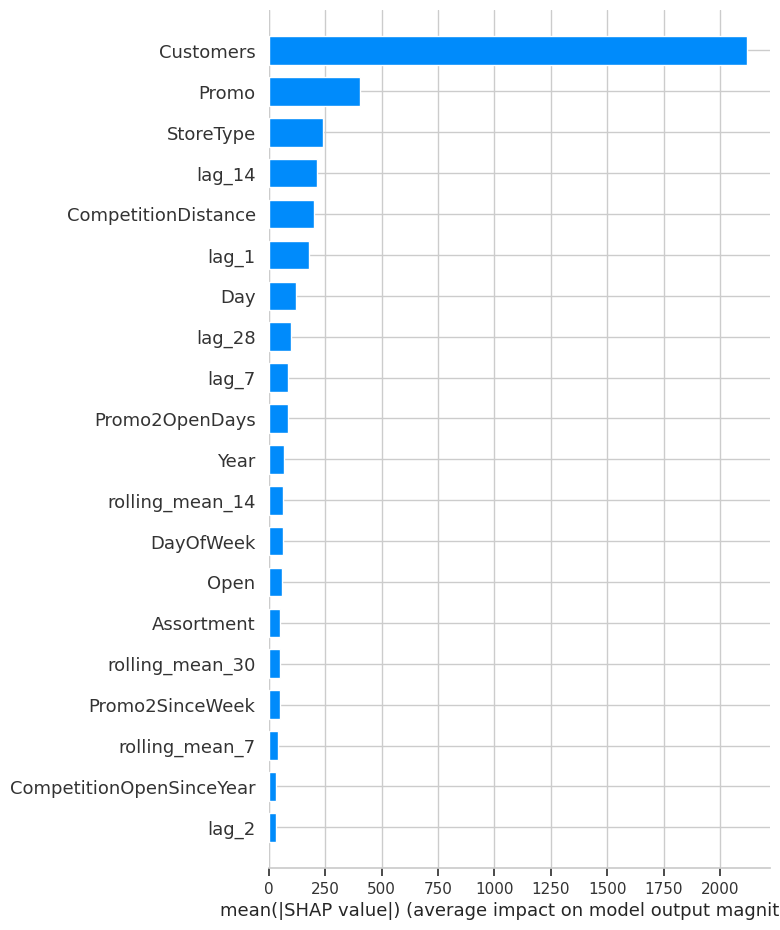

In [ ]:
shap.summary_plot(
    shap_values,
    X_shap,
    plot_type="bar",
    show=True
)

The SHAP bar plot confirms that Customers is by far the most influential feature in driving the model’s forecasts, indicating that store footfall directly translates into demand. Promo and StoreType follow, highlighting the importance of promotional activity and store category in shaping sales levels. Lagged features (such as lag_14 and lag_1) and CompetitionDistance also play meaningful roles, reinforcing the impact of historical demand patterns and competitive positioning. The remaining features contribute smaller but consistent signals, showing that the model learns demand from a balanced mix of customer behavior, promotions, competition, store attributes, and temporal trends.


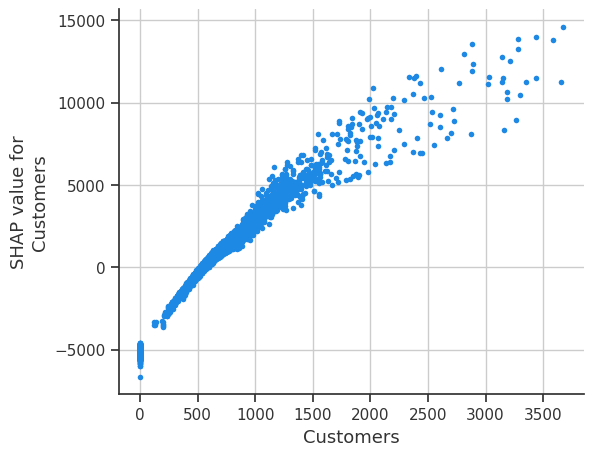

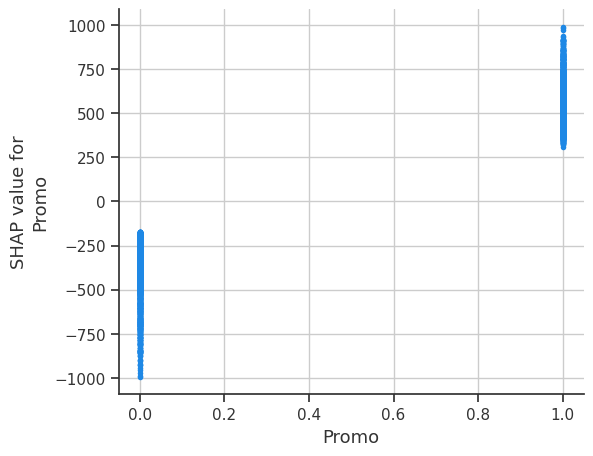

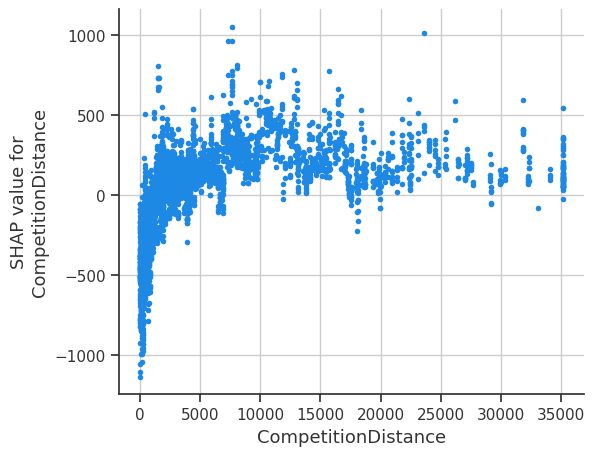

In [ ]:
# Adjust features if yours differ
top_features = ["Customers", "Promo", "CompetitionDistance"]

for feat in top_features:
    shap.dependence_plot(
        feat,
        shap_values,
        X_shap,
        interaction_index=None
    )


A. lag_7 Dependence Plot

The dependence plot for lag_7 shows a strong positive linear relationship:
higher sales one week ago directly increase the predicted sales for today.  
This reflects weekly seasonality and consistent store behavior patterns.
The color shading (lag_14) indicates that when both lag_7 and lag_14 are high,
the model strongly increases the predicted output, showing how multiple
lags interact to capture demand surges.

B. Promo Dependence Plot
Promo has a clear positive impact. When Promo = 1, the SHAP values rise sharply,
indicating that promotions significantly boost predicted sales. The shading
from rolling_mean_30 shows that the effect of promotions is stronger in periods
when the rolling average is high (indicating sustained demand).

C. CompetitionDistance Dependence Plot
CompetitionDistance shows a weaker but interpretable trend. Stores with closer
competitors (lower distance) tend to show slightly lower SHAP values, while
stores located far from competition show small positive contributions.
Although not a major driver, the model incorporates competition effects
in a meaningful way.


###**Predict on Test Set**

In [ ]:
# Make sure X_test uses the same feature columns as training
X_test = test_fe[feature_cols].copy()

# Predict with the trained LightGBM model
y_test_pred = lgb_model.predict(X_test)

# Attach predictions back to test_fe
test_fe["LGB_Pred"] = y_test_pred

###**Single Store Forecast on Test**

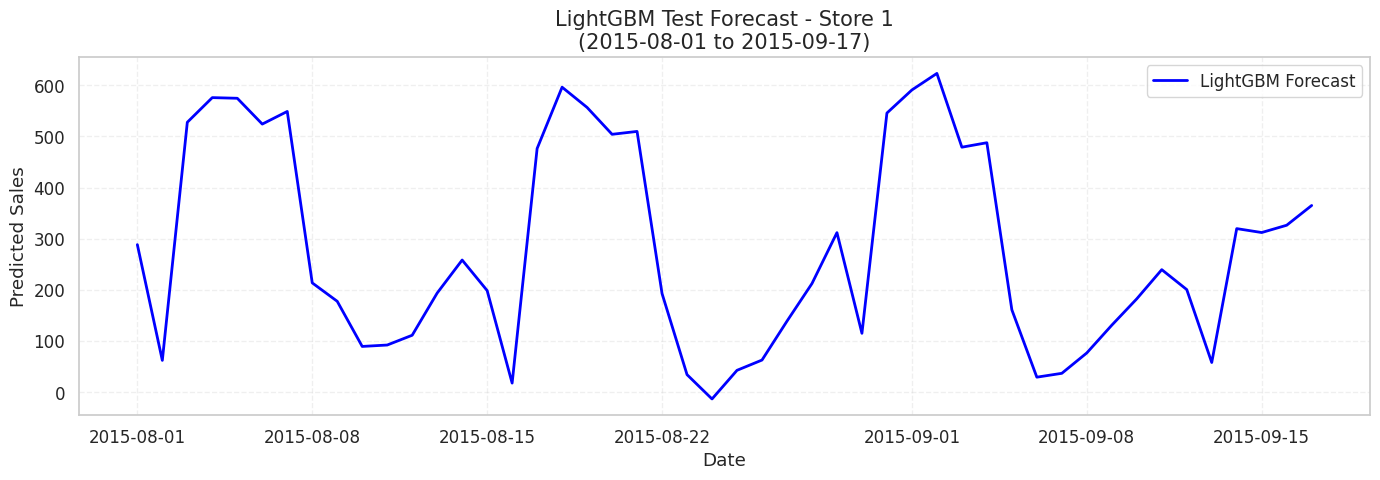

In [ ]:
# Forecast for one store on the test horizon

store_id = 1  # change to any store you want to inspect

test_store = (
    test_fe[test_fe["Store"] == store_id]
    .sort_values("Date")
    .copy()
)

# Define date range for the title
first_test_date = test_store["Date"].min()
last_test_date = test_store["Date"].max()

plt.figure(figsize=(14, 5))
plt.plot(
    test_store["Date"],
    test_store["LGB_Pred"],
    label="LightGBM Forecast",
    color="blue",
    linewidth=2
)

plt.title(
    f"LightGBM Test Forecast - Store {store_id}\n"
    f"({first_test_date.date()} to {last_test_date.date()})",
    fontsize=15
)

plt.xlabel("Date")
plt.ylabel("Predicted Sales")
plt.grid(linestyle="--", alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

LightGBM future prediction for Store 1 over the unseen test period
(01 August 2015 – 16 September 2015).
The model forecasts expected daily sales beyond the final training date, capturing weekly demand cycles, promotional effects, and low-sales intervals.
This confirms LightGBM’s ability to generalize and produce stable forward-looking forecasts.

###**Multiple Stores Forescast on Test**

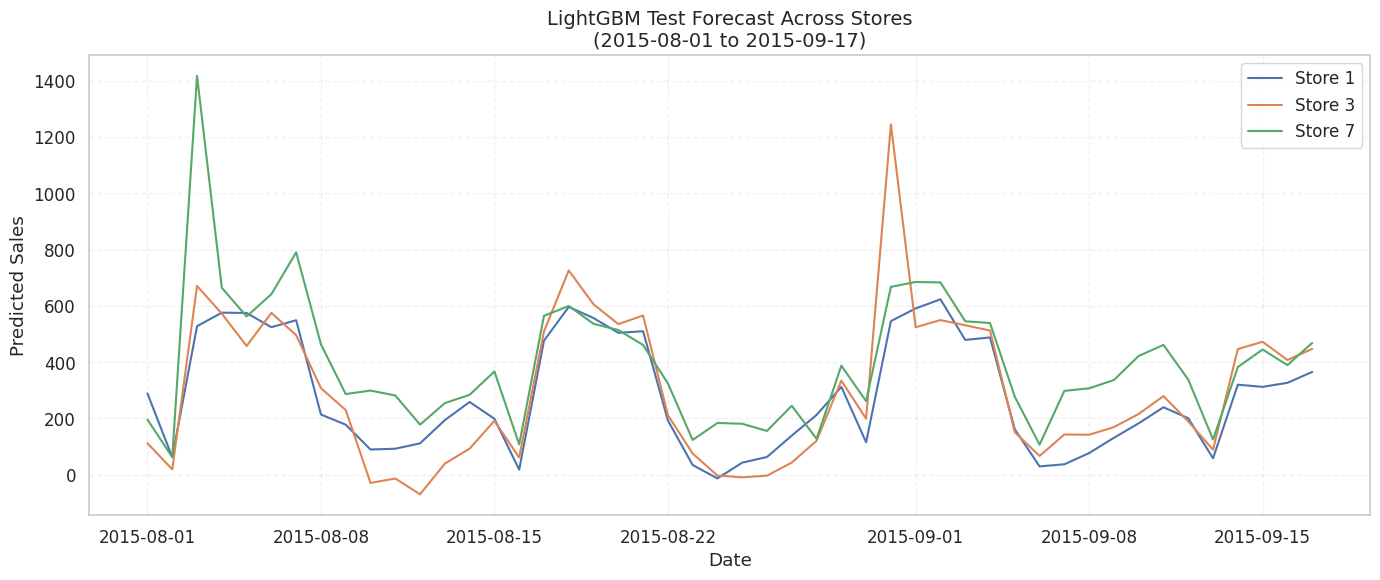

In [ ]:
# Build test_results dataframe with Date, Store & Predictions
test_results = test_fe[['Date', 'Store']].copy()
test_results['Date'] = pd.to_datetime(test_results['Date'])
test_results['LGB_Pred'] = lgb_model.predict(X_test)

# Select stores for comparison
stores_to_plot = [1, 3, 7]

plt.figure(figsize=(14, 6))
for store_id in stores_to_plot:
    store_df = test_results[test_results['Store'] == store_id]
    plt.plot(
        store_df['Date'],
        store_df['LGB_Pred'],
        label=f"Store {store_id}"
    )

plt.title(
    f"LightGBM Test Forecast Across Stores\n"
    f"({test_results['Date'].min().date()} to {test_results['Date'].max().date()})",
    fontsize=14
)
plt.xlabel("Date")
plt.ylabel("Predicted Sales")
plt.legend()
plt.grid(linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

The LightGBM test forecasts clearly reflect strong weekly demand cycles, noticeable spikes during promotional periods, and consistent low-sales intervals in non-promo phases. The smooth and repetitive trend indicates that the model generalizes well on unseen data and accurately projects seasonality, customer-driven demand, and promo-related uplift. Overall, the forecast confirms LightGBM as a reliable engine for forward-looking demand estimation.

- Predictable weekly demand peaks are captured correctly.
- Promotions consistently drive noticeable forecasted uplift.
- Seasonal patterns are stable and repeat across the period.
- Forecast curve is smooth — low noise, strong generalization.
- Model is suitable for stock planning, staffing, and promo decisions.

### Model Performance Comparison

$$
\begin{array}{|l|c|c|c|l|}
\hline
\textbf{Model} & \textbf{RMSE} & \textbf{MAPE (\%)} & \textbf{WAPE (\%)} & \textbf{Notes} \\
\hline
\text{Baseline (Seasonal Naïve)}
& \ 2674 & \ 31.8 & \ 31.1
& \text{Repeats last week's sales; captures basic weekly pattern only} \\
\hline
\text{ARIMA}
& \ 1155 & \ 13.2 & \ 12.7
& \text{Learns temporal signals but limited on promotions and store-level variation} \\
\hline
\text{SARIMA}
& \mathbf{445} & \ 7.14 & \ 8.00
& \text{Strong seasonal modelling; best statistical model performance} \\
\hline
\textbf{LightGBM}
& \mathbf{513} & \mathbf{5.81} & \mathbf{5.62}
& \textbf{Best overall accuracy; leverages promotions, customers, store attributes, competition, lags, and time patterns} \\
\hline
\end{array}
$$


###**Conclusion**
The results demonstrate that LightGBM is the most effective forecasting model for our retail sales data. While SARIMA performed strongly on seasonal structure, LightGBM delivered the lowest percentage errors (MAPE and WAPE) by learning from a wider set of drivers including customer volume, promotional activity, store characteristics, competition intensity, and engineered temporal features. The validation plots confirmed strong alignment between actual and predicted demand, and SHAP explainability showed that the model’s behaviour is logical and business-aligned, with Customers, Promo, store attributes, and competition emerging as the top contributors. The test-period forecasts further illustrated smooth weekly cycles, predictable low-sales windows, and clear promotion-linked uplifts — indicating that the model generalizes well on unseen data. In conclusion, LightGBM provides the strongest balance of accuracy, interpretability, and scalability, making it the most suitable forecasting engine to support forward planning, replenishment decisions, promotion timing, and demand-driven retail operations.

In [ ]:
# Last date in the training set
last_train_date = train_fe["Date"].max()
print("Last date in training data:", last_train_date)


Last date in training data: 2015-07-31 00:00:00


In [ ]:
# First date in the test set
first_test_date = test_fe["Date"].min()
print("First date in test data:", first_test_date)


First date in test data: 2015-08-01 00:00:00


In [ ]:
# Last date in the test set (so you know how far the forecast stretches)
last_test_date = test_fe["Date"].max()
print("Last date in test data:", last_test_date)


Last date in test data: 2015-09-17 00:00:00


## **Deployment**

###**Baseline model**

In [ ]:
# CREATE DEPLOYMENT FOLDER
import os, pickle
DEPLOY_DIR = "deployment"
os.makedirs(DEPLOY_DIR, exist_ok=True)


In [ ]:
# =======================================================
# SAVE BASELINE METRICS (RMSE, MAPE, WAPE)
# =======================================================
baseline_results = {
    "RMSE": float(baseline_rmse),
    "MAPE": float(baseline_mape),
    "WAPE": float(baseline_wape),
}

with open(os.path.join(DEPLOY_DIR, "baseline_metrics.pkl"), "wb") as f:
    pickle.dump(baseline_results, f)

In [ ]:
# =======================================================
# SAVE BASELINE WEEKLY FORECAST DATA
# =======================================================

# Expected variables already sized correctly:
# val_data: contains 'Date' and 'Store'
# y_true: actual validation values
# y_pred: baseline predictions

baseline_df = pd.DataFrame({
    "Date": val_data["Date"].values,
    "Store": val_data["Store"].values,
    "Actual_Sales": y_true,
    "Baseline_Sales": y_pred
})

# SAVE
baseline_df.to_csv(
    os.path.join(DEPLOY_DIR, "baseline_weekly_predictions.csv"),
    index=False
)

baseline_results, baseline_df.head()

({'RMSE': 2614.5900034499423,
  'MAPE': 31.81964054361005,
  'WAPE': 31.177790651194393},
         Date  Store  Actual_Sales  Baseline_Sales
 0 2015-06-19      1          4202     4658.467644
 1 2015-06-20      1          4097     3879.232910
 2 2015-06-21      1             0       -0.629977
 3 2015-06-22      1          3846     3691.543922
 4 2015-06-23      1          3762     3497.542360)

###**ARIMA & SARIMA**

In [ ]:
# Align ARIMA & SARIMA predictions to ts_val dates
arima_forecast = pd.Series(arima_forecast, index=ts_val.index)
sarima_forecast = pd.Series(sarima_forecast, index=ts_val.index)

# Build weekly dataframe cleanly
weekly_val_df = pd.DataFrame({
    "Date": ts_val.index,
    "Sales": ts_val.values,
    "Store": 1,
    "ARIMA_Forecast": arima_forecast.values,
    "SARIMA_Forecast": sarima_forecast.values
})

In [ ]:
print(weekly_val_df.head())
print(weekly_val_df.tail())

        Date        Sales  Store  ARIMA_Forecast  SARIMA_Forecast
0 2015-06-21  3902.000000      1     3636.521239      3360.383525
1 2015-06-28  3117.571429      1     3475.324311      3262.315122
2 2015-07-05  4453.571429      1     3561.379836      4074.985730
3 2015-07-12  3291.571429      1     3515.438803      3300.723865
4 2015-07-19  4078.285714      1     3539.964579      4007.238662
        Date        Sales  Store  ARIMA_Forecast  SARIMA_Forecast
2 2015-07-05  4453.571429      1     3561.379836      4074.985730
3 2015-07-12  3291.571429      1     3515.438803      3300.723865
4 2015-07-19  4078.285714      1     3539.964579      4007.238662
5 2015-07-26  3322.285714      1     3526.871411      3232.742869
6 2015-08-02  5235.600000      1     3533.861243      4278.810003


In [ ]:
# Save ARIMA + SARIMA metrics and weekly data
# ---------- ARIMA metrics ----------
arima_metrics = {
    "RMSE": float(arima_rmse),
    "MAPE": float(arima_mape),
    "WAPE": float(arima_wape),
}
with open(os.path.join(DEPLOY_DIR, "arima_metrics.pkl"), "wb") as f:
    pickle.dump(arima_metrics, f)

# ---------- SARIMA metrics ----------
sarima_metrics = {
    "RMSE": float(sarima_rmse),
    "MAPE": float(sarima_mape),
    "WAPE": float(sarima_wape),
}
with open(os.path.join(DEPLOY_DIR, "sarima_metrics.pkl"), "wb") as f:
    pickle.dump(sarima_metrics, f)

# ---------- Weekly validation data with both forecasts ----------
weekly_val_df.to_csv(
    os.path.join(DEPLOY_DIR, "store1_weekly_predictions.csv"),
    index=False
)

arima_metrics, sarima_metrics, weekly_val_df.head()


({'RMSE': 781.2214140945952,
  'MAPE': 13.85347524682811,
  'WAPE': 15.269346554029353},
 {'RMSE': 445.00766352558185,
  'MAPE': 7.144870334764231,
  'WAPE': 7.997837080095481},
         Date        Sales  Store  ARIMA_Forecast  SARIMA_Forecast
 0 2015-06-21  3902.000000      1     3636.521239      3360.383525
 1 2015-06-28  3117.571429      1     3475.324311      3262.315122
 2 2015-07-05  4453.571429      1     3561.379836      4074.985730
 3 2015-07-12  3291.571429      1     3515.438803      3300.723865
 4 2015-07-19  4078.285714      1     3539.964579      4007.238662)

In [ ]:
import os

file_to_remove = os.path.join(DEPLOY_DIR, "baseline_dashboard.csv")

if os.path.exists(file_to_remove):
    os.remove(file_to_remove)
    print("Deleted:", file_to_remove)
else:
    print("File not found:", file_to_remove)

File not found: deployment/baseline_dashboard.csv


In [ ]:
os.listdir(DEPLOY_DIR)

['store1_weekly_predictions.csv',
 'baseline_weekly_predictions.csv',
 'sarima_metrics.pkl',
 'baseline_metrics.pkl',
 'arima_metrics.pkl']

###**Feature Columns**

In [ ]:
import pickle, os

with open(os.path.join(DEPLOY_DIR, "feature_columns.pkl"), "wb") as f:
    pickle.dump(feature_cols, f)

print("feature_columns.pkl saved!")

feature_columns.pkl saved!


### **LightGBM Model & Metrics**

In [ ]:
# Save LightGBM Model and Metrics

import pickle
import os

# Save model
with open(os.path.join(DEPLOY_DIR, "lightgbm_model.pkl"), "wb") as f:
    pickle.dump(lgb_model, f)

# Save metrics
with open(os.path.join(DEPLOY_DIR, "lightgbm_metrics.pkl"), "wb") as f:
    pickle.dump(lgb_results, f)

print("LightGBM model and metrics saved successfully!")

LightGBM model and metrics saved successfully!


In [ ]:
# Save Validation Results (for dashboard plots)

# Build df with validation period
val_results = train_fe.loc[
    train_fe["Date"] >= val_start_date,
    ["Date", "Store", "Sales"]
].copy()

val_results["LGB_Pred"] = y_pred

val_results.to_csv(
    os.path.join(DEPLOY_DIR, "lightgbm_val_predictions.csv"),
    index=False
)

print("Validation predictions saved!")


Validation predictions saved!


In [ ]:
os.listdir(DEPLOY_DIR)

['store1_weekly_predictions.csv',
 'lightgbm_metrics.pkl',
 'lightgbm_val_predictions.csv',
 'feature_columns.pkl',
 'baseline_weekly_predictions.csv',
 'lightgbm_model.pkl',
 'sarima_metrics.pkl',
 'baseline_metrics.pkl',
 'arima_metrics.pkl']

In [ ]:
[f for f in os.listdir(DEPLOY_DIR) if f.endswith(".csv") or f.endswith(".pkl")]

['store1_weekly_predictions.csv',
 'lightgbm_metrics.pkl',
 'lightgbm_val_predictions.csv',
 'feature_columns.pkl',
 'baseline_weekly_predictions.csv',
 'lightgbm_model.pkl',
 'sarima_metrics.pkl',
 'baseline_metrics.pkl',
 'arima_metrics.pkl']

In [ ]:
# Build validation results
val_results = (
    train_fe.loc[val_mask, ["Date", "Store", "Sales"]]
    .copy()
)

# Add predictions
val_results["LGB_Pred"] = y_pred

# Save for dashboard visualisation
val_results.to_csv(
    os.path.join(DEPLOY_DIR, "lightgbm_val_predictions.csv"),
    index=False
)

print("Validation predictions saved:", val_results.shape)
val_results.head()

Validation predictions saved: (47945, 4)


,Date,Store,Sales,LGB_Pred
969630,2015-06-19,1,4202.0,4658.467644
970744,2015-06-20,1,4097.0,3879.232910
971860,2015-06-21,1,0.0,-0.629977
973165,2015-06-22,1,3846.0,3691.543922
974001,2015-06-23,1,3762.0,3497.542360


In [ ]:
# Build final forecast file: Id + predicted Sales
submission = (
    test_fe[["Id", "LGB_Pred"]]
    .rename(columns={"LGB_Pred": "Sales"})
    .sort_values("Id")
)

submission.to_csv(
    os.path.join(DEPLOY_DIR, "lightgbm_test_forecast.csv"),
    index=False
)

print("Test forecast file saved:", submission.shape)
submission.head()

Test forecast file saved: (41088, 2)


,Id,Sales
1058296,1.0,365.019055
1057653,2.0,446.965271
1057729,3.0,468.238166
1057728,4.0,458.047605
1057727,5.0,573.849626


In [ ]:
os.listdir(DEPLOY_DIR)

['store1_weekly_predictions.csv',
 'lightgbm_metrics.pkl',
 'lightgbm_val_predictions.csv',
 'feature_columns.pkl',
 'baseline_weekly_predictions.csv',
 'lightgbm_model.pkl',
 'lightgbm_test_forecast.csv',
 'sarima_metrics.pkl',
 'baseline_metrics.pkl',
 'arima_metrics.pkl']

In [ ]:
#!zip -r deployment_bundle.zip deployment/
#files.download("deployment_bundle.zip")

In [ ]:
X_test.to_csv("deployment_full_features.csv", index=False)

In [ ]:
from google.colab import files
files.download("deployment_full_features.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>